# Predict Failure of the Pump

## Step 1 Problem Identification

#### Problem Statement: 
    Detect anomalies in the sensor readings from the pump sensors and predict the next failure of the pump with at least 
    75% accuracy. 
        
#### Context:

    Company XYZ operates a water distribution plant that supplies water to the town of ABC. The water distribution system 
    consists of number of pumps and one of the main pumps failed 7 times last year which resulted in an interruption of 
    water supplly for the households in the town and lead to some serious health problems for number of families. The team 
    of reliability engineers could not see any pattern in the data when the system failed and therefore could not identify 
    the cause of the problem. In order to prevent the same failure from happening in the future again, the XYZ company 
    wants to be able to detect the potential issue in advance and be able to control and mitigate the risk of failure. 
    There is one particular pump that is the most important and is equiped with 51 sensors which measure different types of 
    functionalities of the pump. 

#### Criteria For Success:
    A model that predicts with at least 75% accuracy and generalizes on other samples without underfitting or overfitting.

#### Scope of the Solution Space:
    The scope of this project is limited to developing a model that detects anomalies and predicts failures of water pumps 
    based on raw sensor data. The model will not be intended to be used for detecting credit frauds or any other use cases 
    outside the scope of this project. 

#### Contraints:
    Data set is limited to the sensor readings from a single pump hence may not be the best representation of all the 
    pumps. Computing power might become a constraint for effectively visualizing all 51 features at the same time.

#### Stakeholders:
    Samwell Tarly - Maintenance Manager of the XYZ Company

#### Data:
    The data set is sourced from https://www.kaggle.com/nphantawee/pump-sensor-data and consists of 51 numerical features 
    and a categorical label. 51 numerical features contain raw sensor readings from 51 different sensors that are used to 
    do condition monitoring of the pump.The label contains string values that represent normal, broken and recovering 
    operational conditions of the pump. The data set represents 219,521 readings from 51 sensors.   

#### Solution Approach: 

    I will solve this problem by developing a classification model that detects anomalies from the sensor readings and 
    accordingly predicts the potential failure of the pump. To do that, I will first apply an appropriate unsupervised 
    learning techniques to undertake dimensionality reduction for the effective visualization of the data and EDA. Then I 
    will train classification models and will use cross-validation to evaluate their performance to select the best model.

#### Project Deliverables: 
    The deliverables include an app that takes certain features in certain format from a pump and predicts next failure, as 
    well as a slide deck that explains how the app was developed and verified. In addition, all the code will be available 
    in a Jupyter notebook in a GitHub repo for each step of the project.

## Step 4 Pre-processing of the data

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime

#### 4.1: Load the data

In [10]:
# Change the directory to where the data resides
path = 'C:\\Users\\shriy\\OneDrive\\Desktop\\projects\\project1'
os.chdir(path)
# import the tidy data from the Step #2
df=pd.read_csv('processed_data.csv')

#### 4.2: Dummy variable

In [11]:
df['machine_status'].value_counts()

machine_status
NORMAL        205067
RECOVERING     14447
BROKEN             7
Name: count, dtype: int64

I will combine RECOVERING AND BROKEN states under a single class of 0 that implies NOT NORMAL situation. And I will label NORMAL state as 1 that implies NORMAL.

0: NOT NORMAL

1: NORMAL

In [12]:
df2=df.copy()
df2.loc[df2['machine_status'] == 'RECOVERING', 'machine_status'] = 0
df2.loc[df2['machine_status'] == 'BROKEN', 'machine_status'] = 0
df2.loc[df2['machine_status'] == 'NORMAL', 'machine_status'] = 1
df2['machine_status'] = pd.to_numeric(df2['machine_status'])
df2['machine_status'].value_counts()

machine_status
1    205067
0     14454
Name: count, dtype: int64

#### 4.3:  Classes are imbalanced  - Bootstrapping

Address the imbalance in the data by exploring technique mentioned in the following article

https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

In [13]:
# Extract NOT NORMAL for bootstrapping 
NotNormal = df2[df2['machine_status']==0]
# Extract NORMAL 
Normal = df2[df2['machine_status']==1]
# NOT NORMAL
NotNormal.columns

Index(['date', 'sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
       'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
       'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25',
       'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30',
       'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35',
       'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40',
       'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45',
       'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49', 'sensor_50',
       'sensor_51', 'machine_status'],
      dtype='object')

In [14]:
# Bootstrap sample
# Resample observations that is 40% of the original data set
bs_sample=NotNormal.sample(round(0.4*df2.shape[0]), replace=True)

In [15]:
# Check and verify counts
bs_sample['machine_status'].value_counts()

machine_status
0    87808
Name: count, dtype: int64

In [16]:
# Reset the index
bs_sample.reset_index(drop=True, inplace=True)
# Combine bootstrap of NOT NORMAL and NORMAL into single dataframe
dfFinal = pd.concat([bs_sample, Normal]).reset_index(drop=True)
dfFinal['machine_status'].value_counts()

machine_status
1    205067
0     87808
Name: count, dtype: int64

#### 4.4: Feature scaling
The continuous variables in our dataset are at varying scales. For instance if you refer back to the histograms above you can see that the variable “sensor_00” ranges from 0 to 2.54, whilst “sensor_31” ranges from 24 to 1800. This poses a problem for many popular machine learning algorithms which often use Euclidian distance between data points to make the final predictions. Standardising the scale for all continuous variables can often result in an increase in performance of machine learning models. As the values don't follow normal distribution, I will use MinMaxScaler as opposed to StandardScaler.

Useful article about the topic: https://medium.com/vickdata/four-feature-types-and-how-to-transform-them-for-machine-learning-8693e1c24e80

In [17]:
from sklearn import preprocessing
cols = ['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
       'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
       'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25',
       'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30',
       'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35',
       'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40',
       'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45',
       'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49', 'sensor_50',
       'sensor_51']
x = dfFinal[cols]
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
scaled = pd.DataFrame(x_scaled, columns=cols)
add = dfFinal.drop(cols, axis=1)
df_scaled = pd.concat([scaled, add], axis=1)
df_scaled.columns

Index(['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
       'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
       'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25',
       'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30',
       'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35',
       'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40',
       'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45',
       'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49', 'sensor_50',
       'sensor_51', 'date', 'machine_status'],
      dtype='object')

In [18]:
df_scaled['machine_status'].value_counts()

machine_status
1    205067
0     87808
Name: count, dtype: int64

#### 4.5:  Dimensionality Reduction with PCA

In [19]:
# Let's get the data ready
features=['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
       'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
       'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25',
       'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30',
       'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35',
       'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40',
       'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45',
       'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49', 'sensor_50',
       'sensor_51']
x = df_scaled.loc[:, features].values

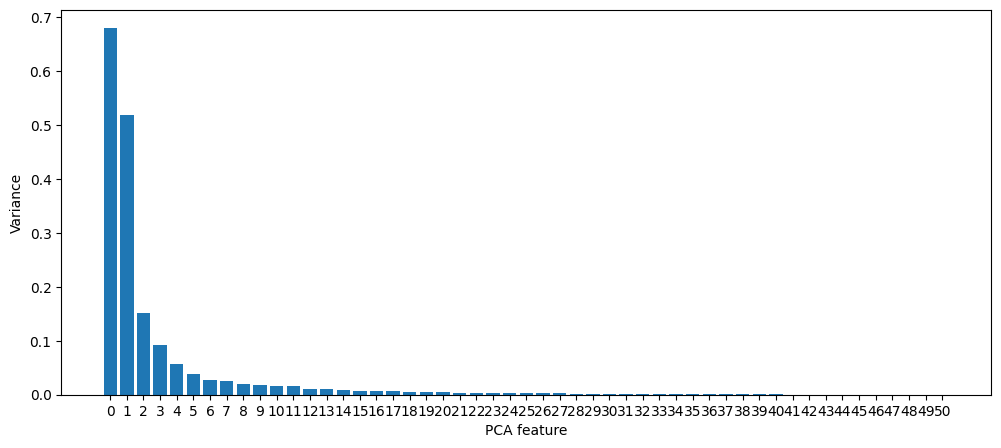

In [20]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x)
p_components = range(pca.n_components_)
_ = plt.figure(figsize=(12,5))
_ = plt.bar(p_components, pca.explained_variance_)
_ = plt.xlabel('PCA feature')
_ = plt.ylabel('Variance')
_ = plt.xticks(p_components)
plt.show()

In [21]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pca1', 'pca2'])

In [22]:
finalDf = pd.concat([principalDf, df_scaled[['machine_status']]], axis = 1)
finalDf.head()

,pca1,pca2,machine_status
0,-0.906797,0.303454,0
1,-1.068777,0.223444,0
2,-1.173625,0.529987,0
3,-1.108630,0.304532,0
4,-0.954060,0.654640,0


In [23]:
finalDf['machine_status'].value_counts()

machine_status
1    205067
0     87808
Name: count, dtype: int64

In [24]:
pca.explained_variance_ratio_

array([0.3861028 , 0.29473799])

## Step 5 Modeling

In [25]:
# Prepare x and y 
features = ['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
       'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
       'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25',
       'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30',
       'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35',
       'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40',
       'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45',
       'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49', 'sensor_50',
       'sensor_51']
x=df2[features]
y=df2['machine_status']
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=21, stratify=y)

#### 5.1: KNN - Unscaled Data

In [26]:
# Train KNN on training set with k=6
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 6)
knn.fit(x_train, y_train)
y_pred=knn.predict(x_test)
knn.score(x_test, y_test)

0.9996355740467984

In [27]:
# Look at the prediction outcome
unique_elements, counts_elements = np.unique(y_pred, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[    0     1]
 [ 4350 61507]]


In [28]:
# Look at the labels from the actual test set
unique_elements, counts_elements = np.unique(y_test, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[    0     1]
 [ 4336 61521]]


#### 5.2: KNN - Scaled Data

In [29]:
# Import libaries
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import warnings
warnings.filterwarnings("ignore")
# Prepare data
x = df2[['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
       'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
       'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25',
       'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30',
       'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35',
       'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40',
       'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45',
       'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49', 'sensor_50',
       'sensor_51']]
y = df2['machine_status']
# Setup the pipeline
steps = [('scaler', StandardScaler()),('knn', KNeighborsClassifier())]
# Create the pipeline
pipeline = Pipeline(steps)
# Setup the hyperparameter grid
param_grid = {'knn__n_neighbors': np.arange(1,15)}
# Create train and test sets (hold-out sets)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)
# Instantiate the GridSearchCV
knn_cv = GridSearchCV(pipeline, param_grid, cv=5)
# Fit to the training set
knn_cv.fit(x_train, y_train)
# Predict the labels of the test set
y_pred = knn_cv.predict(x_test)
# Compute and print metrics
print("Accuracy: {}".format(knn_cv.best_score_))
print(classification_report(y_test, y_pred))
print("Tuned Model Parameters: {}".format(knn_cv.best_params_))

Accuracy: 0.9998893695211051
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4336
           1       1.00      1.00      1.00     61521

    accuracy                           1.00     65857
   macro avg       1.00      1.00      1.00     65857
weighted avg       1.00      1.00      1.00     65857

Tuned Model Parameters: {'knn__n_neighbors': 1}


In [30]:
unique_elements, counts_elements = np.unique(y_pred, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[    0     1]
 [ 4334 61523]]


#### 5.3: KNN - PCA

In [31]:
# Import libaries
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import warnings
# Prepare x and y - let's start with four features (sensors 04, 28, 31, 36) as per what was discovered from EDA
x=finalDf[['pca1', 'pca2']]
y=finalDf['machine_status']
# Set up steps
steps = [('knn', KNeighborsClassifier())]
# Create the pipeline
pipeline = Pipeline(steps)
# Setup the hyperparameter grid
param_grid = {'knn__n_neighbors': np.arange(1,50)}
# Create train and test sets (hold-out sets)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)
# Instantiate the GridSearchCV
knn_cv = GridSearchCV(pipeline, param_grid, cv=5)
# Fit to the training set
knn_cv.fit(x_train, y_train)
# Predict the labels of the test set
y_pred = knn_cv.predict(x_test)
# Compute and print metrics
print("Accuracy: {}".format(knn_cv.best_score_))
print(classification_report(y_test, y_pred))
print("Tuned Model Parameters: {}".format(knn_cv.best_params_))

Accuracy: 0.9973562522213903
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     26343
           1       1.00      1.00      1.00     61520

    accuracy                           1.00     87863
   macro avg       1.00      1.00      1.00     87863
weighted avg       1.00      1.00      1.00     87863

Tuned Model Parameters: {'knn__n_neighbors': 1}


#### 5.4: Logistic Regression - Unscaled Data

In [32]:
# Import libaries
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import warnings
warnings.filterwarnings("ignore")
# Prepare data
x = df2[['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
       'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
       'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25',
       'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30',
       'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35',
       'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40',
       'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45',
       'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49', 'sensor_50',
       'sensor_51']]
y = df2['machine_status']
# Setup the pipeline
steps = [('logreg', LogisticRegression())]
# Create the pipeline
pipeline = Pipeline(steps)
# Setup the hyperparameter grid
param_grid = {'logreg__C': np.logspace(-5, 8, 15)}
# Create train and test sets (hold-out sets)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)
# Instantiate the GridSearchCV
logreg_cv = GridSearchCV(pipeline, param_grid, cv=5)
# Fit to the training set
logreg_cv.fit(x_train, y_train)
# Predict the labels of the test set
y_pred = logreg_cv.predict(x_test)
# Compute and print metrics
print("Accuracy: {}".format(logreg_cv.score(x_test, y_test)))
print(classification_report(y_test, y_pred))
print("Tuned Model Parameters: {}".format(logreg_cv.best_params_))

Accuracy: 0.9959153924411983
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4336
           1       1.00      1.00      1.00     61521

    accuracy                           1.00     65857
   macro avg       0.98      0.99      0.98     65857
weighted avg       1.00      1.00      1.00     65857

Tuned Model Parameters: {'logreg__C': 0.4393970560760795}


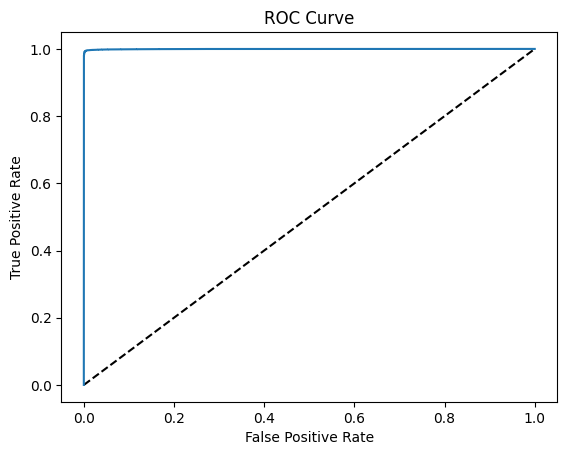

In [33]:
# ROC curve
# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg_cv.predict_proba(x_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

#### 5.5: Logistic Regression - Scaled Data

In [34]:
# Import libaries
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import warnings
warnings.filterwarnings("ignore")
# Prepare data
x = df2[['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
       'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
       'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25',
       'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30',
       'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35',
       'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40',
       'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45',
       'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49', 'sensor_50',
       'sensor_51']]
y = df2['machine_status']
# Setup the pipeline
steps = [('scaler', StandardScaler()), ('logreg', LogisticRegression())]
# Create the pipeline
pipeline = Pipeline(steps)
# Setup the hyperparameter grid
param_grid = {'logreg__C': np.logspace(-5, 8, 15)}
# Create train and test sets (hold-out sets)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)
# Instantiate the GridSearchCV
logreg_cv = GridSearchCV(pipeline, param_grid, cv=5)
# Fit to the training set
logreg_cv.fit(x_train, y_train)
# Predict the labels of the test set
y_pred = logreg_cv.predict(x_test)
# Compute and print metrics
print("Accuracy: {}".format(logreg_cv.score(x_test, y_test)))
print(classification_report(y_test, y_pred))
print("Tuned Model Parameters: {}".format(logreg_cv.best_params_))

Accuracy: 0.9981323169898416
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4336
           1       1.00      1.00      1.00     61521

    accuracy                           1.00     65857
   macro avg       0.99      0.99      0.99     65857
weighted avg       1.00      1.00      1.00     65857

Tuned Model Parameters: {'logreg__C': 2275.845926074791}


#### 5.6: Logistic Regression - PCA

In [35]:
x=finalDf[['pca1', 'pca2']]
y=finalDf['machine_status']
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=21, stratify=y)
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[26186   157]
 [  653 60867]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     26343
           1       1.00      0.99      0.99     61520

    accuracy                           0.99     87863
   macro avg       0.99      0.99      0.99     87863
weighted avg       0.99      0.99      0.99     87863



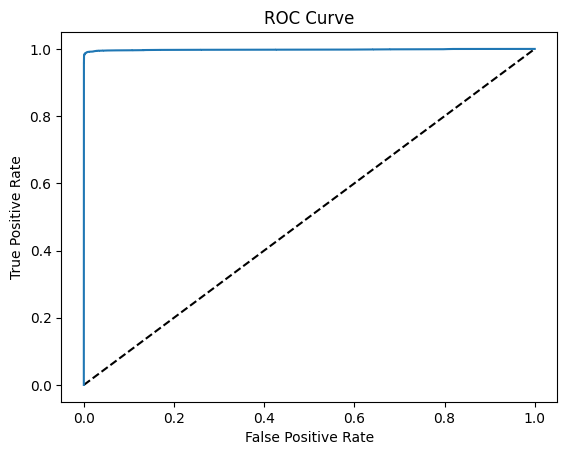

In [36]:
# ROC curve
# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(x_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

#### 5.7: Decision Tree

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import warnings
warnings.filterwarnings('ignore')
# Declare a variable called gini_model and use tree.DecisionTreeClassifier. 
gini_model = tree.DecisionTreeClassifier(criterion='gini', random_state=46)
# Set up pipeline steps
steps = [('gini', gini_model)]
pipeline = Pipeline(steps)
# Declare max_depth parameter values
param_grid = {'gini__max_depth': [0, 3, 5, 7, 9]}
# Instantiate GridSearchCV
gini_cv = GridSearchCV(pipeline, param_grid, cv=5)
# Call fit() on entr_model
gini_cv.fit(x_train, y_train)
# Call predict() on entr_model with X_test passed to it, and assign the result to a variable y_pred 
y_pred = gini_cv.predict(x_test)
# Call Series on our y_pred variable with the following: pd.Series(y_pred)
pd.Series(y_pred)
# Check out entr_model
gini_cv

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('gini',
                                        DecisionTreeClassifier(random_state=46))]),
             param_grid={'gini__max_depth': [0, 3, 5, 7, 9]})

In [38]:
# Evaulate the cross-validation gini model
from sklearn import metrics
print("Gini impurity model - Cross Validation")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score' , metrics.precision_score(y_test,y_pred, pos_label = 1))
print('Recall score' , metrics.recall_score(y_test,y_pred, pos_label = 0))
print("Tuned Model Parameters: {}".format(gini_cv.best_params_))

Gini impurity model - Cross Validation
Accuracy: 0.995242593583192
Balanced accuracy: 0.9955391430852176
Precision score 0.9984012528956899
Recall score 0.9962798466385757
Tuned Model Parameters: {'gini__max_depth': 9}


In [39]:
np.unique(y_pred, return_counts=True)

(array([0, 1], dtype=int64), array([26565, 61298], dtype=int64))

In [40]:
np.unique(y_test, return_counts=True)

(array([0, 1], dtype=int64), array([26343, 61520], dtype=int64))

#### 5.8 Random Forest

In [41]:
# Import the necessary libraries
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
# Instantiate Random Forest Classifier
rf = RandomForestClassifier(random_state=46)
# Fit the model to the training set
rf.fit(x_train, y_train)
# Predict with the model
y_pred = rf.predict(x_test)
# Call Series on our y_pred variable with the following: pd.Series(y_pred)
y_pred = pd.Series(y_pred)

In [42]:
# Evaulate the Random Forest
from sklearn import metrics
print("Random Forest")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score' , metrics.precision_score(y_test,y_pred, pos_label = 1))
print('Recall score' , metrics.recall_score(y_test,y_pred, pos_label = 0))

Random Forest
Accuracy: 0.9975985340814677
Balanced accuracy: 0.9981874341086063
Precision score 0.9998532457155902
Recall score 0.9996583532627263
